# NeuralGCM Quick Start

[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_ncat/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/ml_tutorial_ncat/blob/main/code/neuralGCM_inference_demo.ipynb)

This is a slightly modified copy of the NeuralGCM [quickstart notebook](https://neuralgcm.readthedocs.io/en/latest/inference_demo.html) that can be run in Colaboratory.

## Environment for local execution
Environment creation is only necessary if you are running the code locally. If you are running in Colaboratory this can be skipped.
```
# for CPU only
conda create --name neuralgcm-cpu python
conda activate neuralgcm-cpu
pip install neuralgcm ipykernel matplotlib
pip install -U "jax==0.4.33"
```

In [1]:
# if necessary, install NeuralGCM and dependencies
! pip install -q -U neuralgcm dinosaur-dycore gcsfs
! pip install zarr==2.18.4

  Attempting uninstall: zarr
    Found existing installation: zarr 2.18.3
    Uninstalling zarr-2.18.3:
      Successfully uninstalled zarr-2.18.3


## Forecasting quick start

### Data
This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

### Workflow
The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

### Model
By default the notebook uses intermediate deterministic NeuralGCM 1.4° model. Other available checkpoints include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations.

### Additional References
* <https://neuralgcm.readthedocs.io/en/latest/installation.html>
* <https://neuralgcm.readthedocs.io/en/latest/inference_demo.html>
* <https://github.com/google-research/neuralgcm>
* <https://cloud.google.com/storage/docs/public-datasets/era5>

In [2]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray
import zarr

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token='anon')

print(zarr.__version__)
print(xarray.__version__)

2.18.4
2024.9.0


## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`



In [3]:
model_name = 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Modify forecast dates

In [4]:
"""
This script is a demonstration of neuralGCM inference.

Attributes:
    demo_start_time (str): The start date for the demonstration in 'YYYY-MM-DD' format.
    demo_end_time (str): The end date for the demonstration in 'YYYY-MM-DD' format.
"""
demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'

## Load ERA5 data from GCP/Zarr

Select out a few days of data:

In [5]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

Regrid to NeuralGCM's native resolution:

In [6]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

## Make the forecast

See {doc}`trained_models` for details.

In [7]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

In [8]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

/opt/homebrew/Caskroom/miniforge/base/envs/neuralgcm-cpu/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


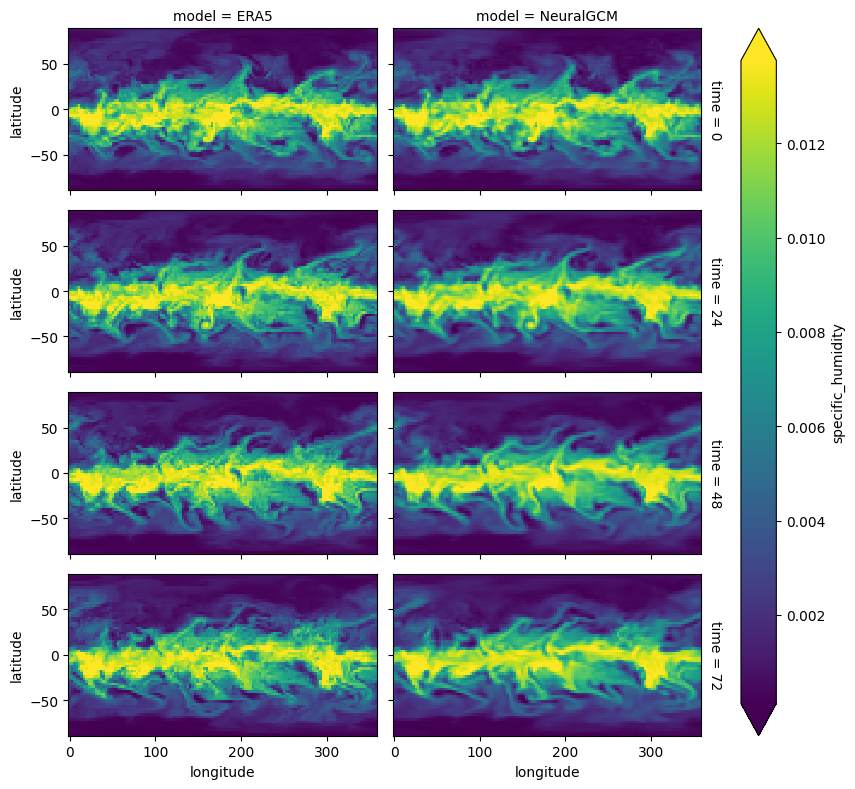

In [9]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
)